# Pysindy with DEC data

In [1]:
import dctkit as dt
from dctkit import config
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from dctkit.mesh import util
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.dec import cochain as C
from dctkit.dec.vector import flat_PDP as flat
from matplotlib import cm
import pysindy as ps
from alpine.data.util import load_dataset
from alpine.data.burgers.burgers_dataset import data_path
from dctkit.physics import burgers as b
import math

In [2]:
config()

In [3]:
# SPACE PARAMS
# spatial resolution
dx = 5/2**8
L = 5 + dx
dx_norm = dx/L
L_norm = 1
#  Number of spatial grid points
num_x_points = int(math.ceil(L / dx))
num_x_points_norm = num_x_points

# vector containing spatial points
x = np.linspace(0, L, num_x_points)
x_circ = (x[:-1] + x[1:])/2

# initial velocity
u_0 = 2 * np.exp(-2 * (x_circ - 0.5 * L)**2)
umax = np.max(u_0)

# TIME PARAMS
T = 2
T_norm = T*umax/L
# temporal resolution
dt = 2/2**10
dt_norm = dt*umax/L
# number of temporal grid points
num_t_points_norm = int(math.ceil(T_norm / dt_norm))


t = np.linspace(0, T_norm, num_t_points_norm)

# Viscosity
epsilon = 0.05
epsilon_norm = epsilon/(L*umax)

nodes_BC = {'left': np.zeros(num_t_points_norm),
                'right': np.zeros(num_t_points_norm)}

In [4]:
# generate mesh
mesh, _ = util.generate_line_mesh(num_x_points_norm, L_norm)
S = util.build_complex_from_mesh(mesh)
S.get_hodge_star()
S.get_flat_PDP_weights()
# get circ
circ = S.circ[1][:,0]

In [5]:
# load data
time_train, time_val, time_test, u_train_T, u_val_T, u_test_T = load_dataset(
    data_path, "npy")

In [6]:
# construct full u (only for plotting and u_dot)
prb = b.Burgers(L_norm, T_norm, dx_norm, dt_norm, u_0/umax, nodes_BC, epsilon_norm)
prb.run("parabolic")

In [7]:
u = prb.u
u_dot_true = ps.FiniteDifference(axis=1)._differentiate(u, t=dt_norm)

In [8]:
# define skip_dx and skip_dt
skip_dx = 2**2
skip_dt = 2**5

# define sub-sampled mesh and time interval
t_sample = t[::skip_dt]
circ_sample = circ[::skip_dx]

u_sample = u[::skip_dx, ::skip_dt]
u_dot_sample = u_dot_true[::skip_dx, ::skip_dt]

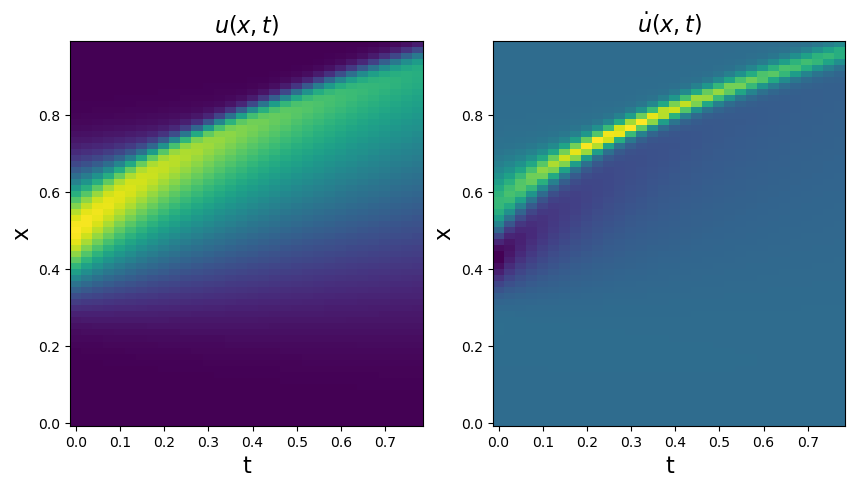

In [9]:
# PLOT FULL DATA
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t_sample, circ_sample, u_sample)
ax[1].pcolormesh(t_sample,circ_sample,u_dot_sample)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

## Training

In [10]:
# define u_training
training_time = np.concatenate((time_train, time_val))
t_training = t_sample[training_time]
u_training = np.vstack((u_train_T, u_val_T)).T

# define u_training_dot
u_dot_training_true = u_dot_sample[:, training_time]

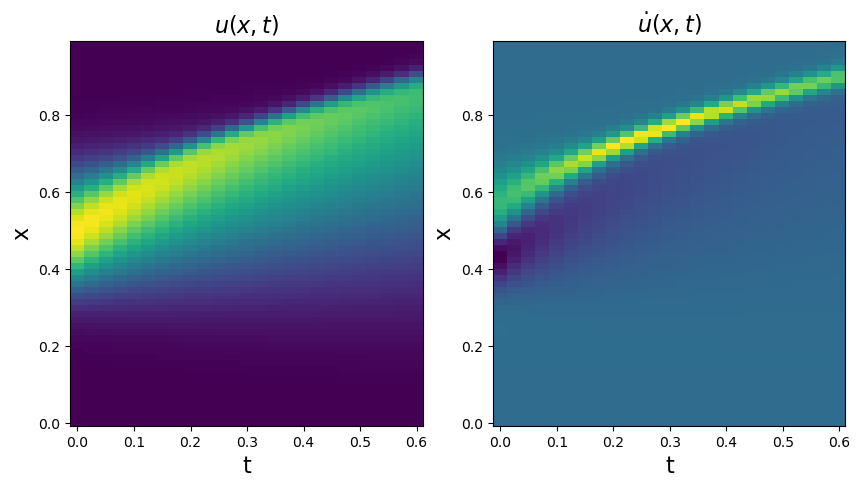

In [11]:
# PRINT TRAINING DATA
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t_training, circ_sample, u_training)
ax[1].pcolormesh(t_training,circ_sample,u_dot_training_true)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$u(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()

In [12]:
# reshape u_training and u_dot_training
u_training_reshape = u_training.reshape(len(circ_sample), len(training_time), 1)
u_training_dot_reshape = u_dot_training_true.reshape(u_dot_training_true.shape[0], 
                                                     u_dot_training_true.shape[1], 1)

In [13]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=5,
    spatial_grid=circ_sample,
    is_uniform=True,
)

optimizer = ps.STLSQ(threshold=2, alpha=1e-4, normalize_columns=True, verbose=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

In [14]:
# fit without u_t
print('STLSQ model:')
model.fit(u_training_reshape, t=dt_norm*skip_dt)
model.print()

STLSQ model:
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 4.0836e+00 ... 4.1687e-01 ...         12 ... 4.5004e+00
         1 ... 6.3485e+00 ... 4.3693e-01 ...         11 ... 6.7854e+00
         2 ... 8.3093e+00 ... 4.4936e-01 ...          9 ... 8.7587e+00
         3 ... 7.5465e+00 ... 4.3947e-01 ...          6 ... 7.9859e+00
         4 ... 3.4542e+00 ... 4.3196e-01 ...          5 ... 3.8862e+00
         5 ... 3.4459e+00 ... 4.3118e-01 ...          5 ... 3.8771e+00
(x0)' = 0.006 x0_11 + -0.995 x0x0_1


In [15]:
# compute training error
u_dot_training = model.predict(u_training_reshape)[:,:,0]
print(np.mean(np.linalg.norm(u_dot_training_true - u_dot_training, axis=0)**2))

0.37509460864367433


## Test

In [16]:
# defining u_test
u_test = u_test_T.T
u_test_reshape = u_test.reshape(u_test.shape[0], u_test.shape[1], 1)

In [17]:
# define u_dot_test_true and compute u_test
t_test = t[time_test]
u_dot_test_true = u_dot_sample[:, time_test]
u_dot_test = model.predict(u_test_reshape)[:,:,0]

In [18]:
# compute test error
print(np.mean(np.linalg.norm(u_dot_test_true - u_dot_test, axis=0)**2))

2.3442301416011277


## True $\dot{u}$ vs computed $\dot{u}$

In [19]:
# reconstruct u_dot_true_model
u_dot_model = np.zeros_like(u_sample)
u_dot_model[:, training_time] = u_dot_training
u_dot_model[:, time_test] = u_dot_test

In [20]:
# compute total error
print(np.mean(np.linalg.norm(u_dot_model - u_dot_sample, axis=0)**2))

0.8058430064781172


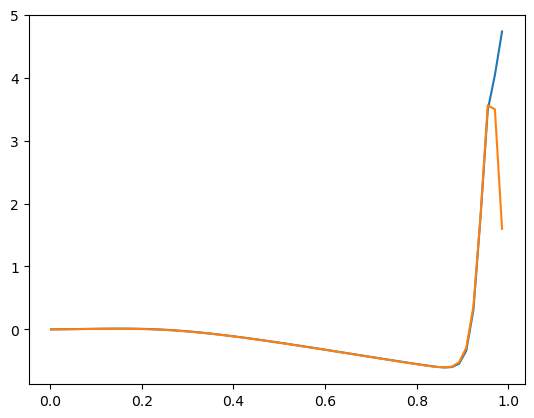

In [21]:
# COMPARISON udot_true VS udot_predict 
# check u_dot profile in the last test time
single_test_time = time_test[-1]
plt.plot(circ_sample, u_dot_model[:,single_test_time])
plt.plot(circ_sample, u_dot_sample[:, single_test_time])
plt.show()

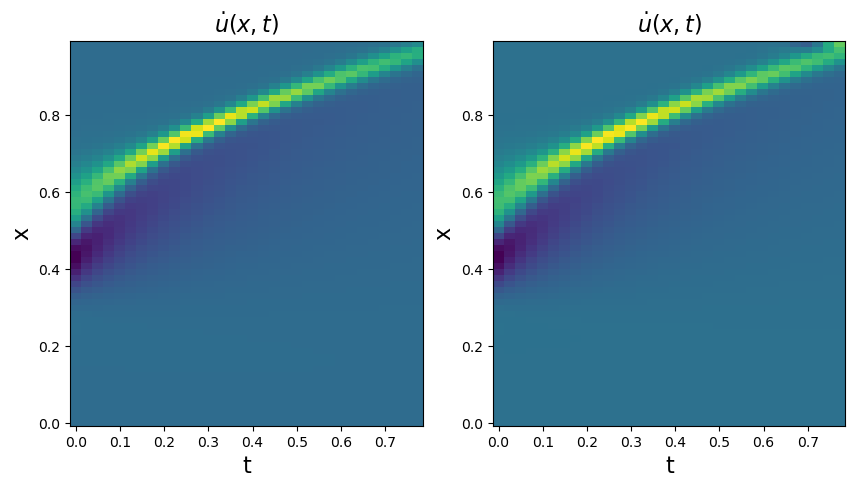

In [23]:
# COMPARISON udot_true VS udot_predict 
fig1, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].pcolormesh(t_sample,circ_sample,u_dot_sample)
ax[1].pcolormesh(t_sample, circ_sample, u_dot_model)
ax[0].set_xlabel('t', fontsize=16)
ax[0].set_ylabel('x', fontsize=16)
ax[0].set_title(r'$\dot{u}(x, t)$', fontsize=16)
ax[1].set_xlabel('t', fontsize=16)
ax[1].set_ylabel('x', fontsize=16)
ax[1].set_title(r'$\dot{u}(x, t)$', fontsize=16)
plt.show()